In [84]:
import cv2
import glob
import os

# ✅ Define your image folder path
image_folder = r"C:\Users\Banty\OneDrive\Desktop\Python\3D object\images"  # Update this path

# ✅ Load images (supports JPG, PNG)
image_files = sorted(glob.glob(os.path.join(image_folder, "*.jpg"))) \

# ✅ Check if images exist
if len(image_files) == 0:
    print("❌ No images found! Check folder path and image formats.")
    exit()

# ✅ Load images using OpenCV
images = [cv2.imread(img) for img in image_files if cv2.imread(img) is not None]

# ✅ Verify images loaded
print(f"✅ Successfully loaded {len(images)} images.")


✅ Successfully loaded 4 images.


In [85]:
# ✅ Convert images to grayscale (only if images are loaded)
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

# ✅ Ensure grayscale images are loaded
if len(gray_images) < 2:
    print("❌ Need at least 2 images for 3D reconstruction!")
    exit()


In [86]:
# ✅ Initialize ORB detector
orb = cv2.ORB_create(nfeatures=5000)

# ✅ Detect keypoints & descriptors
keypoints, descriptors = [], []
for img in gray_images:
    kp, des = orb.detectAndCompute(img, None)
    keypoints.append(kp)
    descriptors.append(des if des is not None else [])

# ✅ Ensure valid descriptors exist
if len(descriptors) < 2 or len(descriptors[0]) == 0 or len(descriptors[1]) == 0:
    print("❌ Not enough feature descriptors found!")
    exit()

# ✅ FLANN-based feature matching
FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=12, key_size=20, multi_probe_level=2)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors[0], descriptors[1], k=2)

# ✅ Apply Lowe's Ratio Test
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
print(f"✅ Found {len(good_matches)} good matches.")


✅ Found 30 good matches.


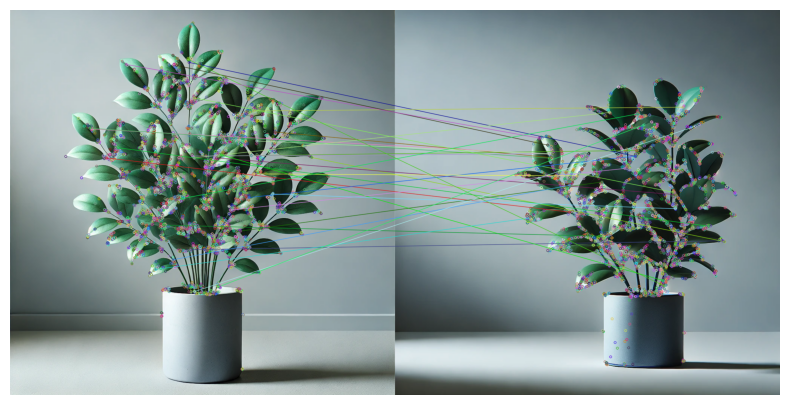

In [87]:
import matplotlib.pyplot as plt

# ✅ Draw matches between first two images
img_matches = cv2.drawMatches(images[0], keypoints[0], images[1], keypoints[1], good_matches[:50], None)

# ✅ Display using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(img_matches)
plt.axis("off")
plt.show()


In [88]:
import numpy as np

# ✅ Extract matched keypoints
pts1 = np.float32([keypoints[0][m.queryIdx].pt for m in good_matches])
pts2 = np.float32([keypoints[1][m.trainIdx].pt for m in good_matches])

# ✅ Camera intrinsic matrix (Assumed values)
K = np.array([[1000, 0, images[0].shape[1]//2],
              [0, 1000, images[0].shape[0]//2],
              [0, 0, 1]])

# ✅ Compute fundamental & essential matrices
F, _ = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
E = K.T @ F @ K

# ✅ Recover pose (rotation R and translation t)
_, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)


In [89]:
# ✅ Define Projection Matrices
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))  # Camera 1
P2 = np.hstack((R, t))  # Camera 2

# ✅ Convert points to homogeneous coordinates
pts1_h = cv2.undistortPoints(np.expand_dims(pts1, axis=1), K, None)
pts2_h = cv2.undistortPoints(np.expand_dims(pts2, axis=1), K, None)

# ✅ Triangulate 3D points
points_4d = cv2.triangulatePoints(P1, P2, pts1_h, pts2_h)

# ✅ Convert to 3D coordinates
points_3d = (points_4d[:3] / points_4d[3]).T


In [90]:
import open3d as o3d

# Create a Point Cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)  # Ensure `points_3d` contains valid 3D points

# Open in an external Open3D window
# vis = o3d.visualization.Visualizer()
# vis.create_window()  # Creates an external window
# vis.add_geometry(pcd)
# vis.run()
# vis.destroy_window()

o3d.visualization.draw_geometries([pcd], window_name="3D Reconstruction", width=800, height=600)
